In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 12.2 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 25.2 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 850 µs


### Database ERD

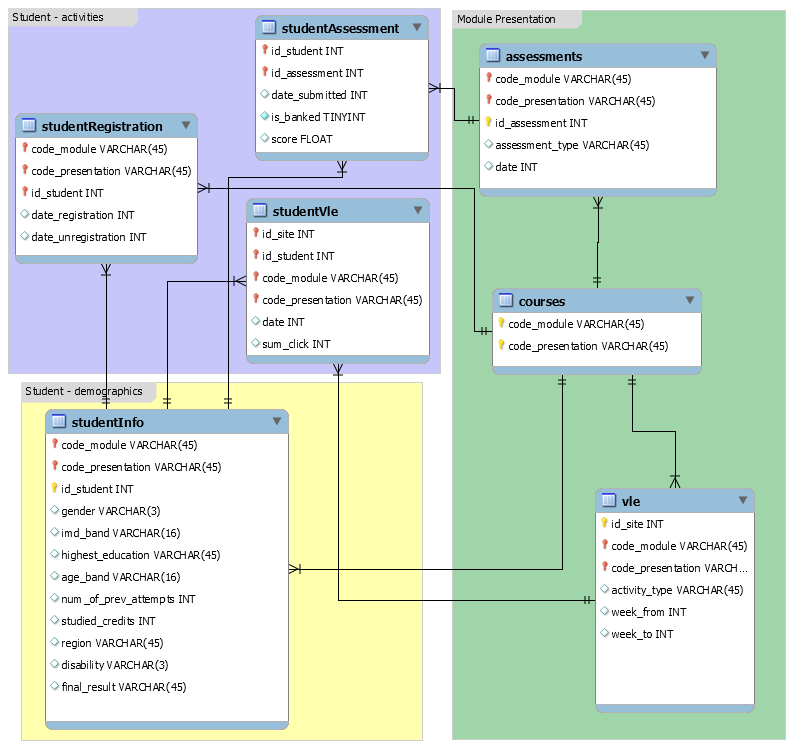

time: 7.25 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.7 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 7.35 ms


## Three-Quarter Term Data

In [8]:
# database_name = 'outcomes.db'
# db_new = db.Database(database_name)

time: 843 µs


In [9]:
df = db.data_prep(180)

time: 19.3 s


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23269 entries, 0 to 23268
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target                21922 non-null  float64
 1   row_id                23269 non-null  object 
 2   score                 21903 non-null  object 
 3   gender                21922 non-null  object 
 4   region                21922 non-null  object 
 5   highest_education     21922 non-null  object 
 6   imd_band              21040 non-null  object 
 7   age_band              21922 non-null  object 
 8   num_of_prev_attempts  21922 non-null  object 
 9   studied_credits       21922 non-null  float64
 10  disability            21922 non-null  object 
 11  final_result          21922 non-null  object 
 12  date_sub              21922 non-null  float64
 13  course_length         21922 non-null  float64
 14  weighted_ave          21917 non-null  float64
 15  mean_score         

In [11]:
df.describe()

,target,studied_credits,date_sub,course_length,weighted_ave,mean_score,median_score,sum_activity,max_date,date_registration,date_unregistration
count,21922.000000,21922.000000,21922.000000,21922.000000,21917.000000,21917.000000,21917.000000,21922.000000,21922.000000,23269.000000,754.000000
mean,0.298787,74.980385,25.928063,239.664173,189.691350,74.678502,75.341288,1688.398504,-8.545753,-65.372427,211.066313
std,0.457737,36.912817,16.660349,5.637198,118.898495,14.465158,14.655536,1786.562764,12.320349,46.963802,17.973741
min,0.000000,30.000000,-11.000000,234.000000,0.000000,0.000000,0.000000,2.000000,-25.000000,-310.000000,181.000000
25%,0.000000,60.000000,18.000000,240.000000,101.200000,67.000000,67.500000,523.000000,-17.000000,-94.000000,198.000000
50%,0.000000,60.000000,21.000000,240.000000,203.520000,77.500000,78.000000,1104.000000,-10.000000,-52.000000,212.000000
75%,1.000000,90.000000,31.000000,241.000000,265.200000,85.222222,86.000000,2219.000000,-4.000000,-29.000000,223.000000
max,1.000000,630.000000,179.000000,268.000000,867.240000,100.000000,100.000000,20585.000000,173.000000,167.000000,444.000000


time: 85.6 ms


In [12]:
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration', 'max_date']

time: 950 µs


In [13]:
df = db.pipe_cleaner_wa(df, drops)

time: 73.4 ms


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19812 entries, 1 to 23268
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                19812 non-null  float64 
 1   gender                19812 non-null  object  
 2   region                19812 non-null  object  
 3   highest_education     19812 non-null  object  
 4   imd_band              19812 non-null  object  
 5   age_band              19812 non-null  object  
 6   num_of_prev_attempts  19812 non-null  object  
 7   disability            19812 non-null  object  
 8   weighted_ave          19812 non-null  float64 
 9   mean_score            19812 non-null  float64 
 10  median_score          19812 non-null  float64 
 11  sum_activity          19812 non-null  float64 
 12  course_load           19812 non-null  category
dtypes: category(1), float64(5), object(7)
memory usage: 2.0+ MB
time: 21.6 ms


In [16]:
df.target.value_counts(normalize=True)

0.0    0.697204
1.0    0.302796
Name: target, dtype: float64

time: 28.7 ms


## Creating Holdout Data

In [17]:
# splitting data & target
X, y = f.X_y(df)

time: 11.4 ms


In [18]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 48.3 ms


## Creating Training Data

In [19]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 48.5 ms


## Baseline Model: Dummy Classifier

In [20]:
dummy = DummyClassifier(strategy='most_frequent')

time: 14.3 ms


In [21]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 2.11 ms


### Fitting Model

In [22]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 107 ms


### Saving Model

In [23]:
# f.pickle_model(baseline, 'baseline')

time: 1.62 ms


### Cross Val Scores

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.6972362033678788
 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0
time: 538 ms


### Test Data Confusion Matrix

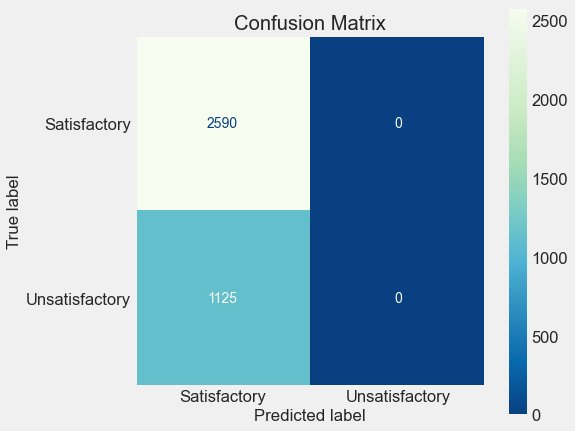

,Accuracy,F1,Recall,Precision
0,0.697174,0.0,0.0,0.0


time: 493 ms


In [25]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## First Simple Model: Naive Bayes Classifier

In [26]:
mnb = MultinomialNB()

time: 1.08 ms


In [27]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 1.12 ms


### Fitting Model

In [28]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>)])),
                ('multinomialnb', MultinomialNB())])

time: 71.8 ms


### Saving Model

In [29]:
# f.pickle_model(fsm, 'fsm')

time: 857 µs


### Cross Val Scores

In [30]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.7001080098876166
 fsm has an average F1 of 0.19683415999672868
 fsm has an average Recall of 0.12152236509506538
 fsm has an average Precision of 0.5193270860004521


[0.7001080098876166,
 0.19683415999672868,
 0.12152236509506538,
 0.5193270860004521]

time: 270 ms


### Test Data Confusion Matrix

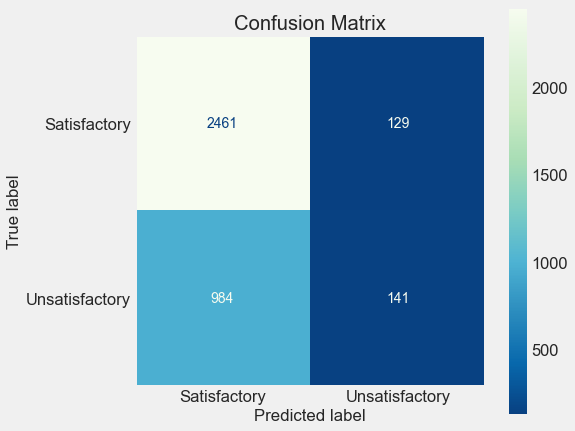

,Accuracy,F1,Recall,Precision
0,0.700404,0.202151,0.125333,0.522222


time: 1.35 s


In [31]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

# Standard Scaling

## KNeighborsClassifier

In [32]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 2.69 ms


In [33]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 2.54 ms


### Fitting Model

In [34]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 250 ms


In [35]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 1.59 ms


### Cross Val Scores

In [36]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.7745869487649741
knn_ss has an average F1 of 0.5827800976316395
knn_ss has an average Recall of 0.5201543026706232
knn_ss has an average Precision of 0.662808065155991


[0.7745869487649741, 0.5827800976316395, 0.5201543026706232, 0.662808065155991]

time: 10.2 s


### Test Data Confusion Matrix

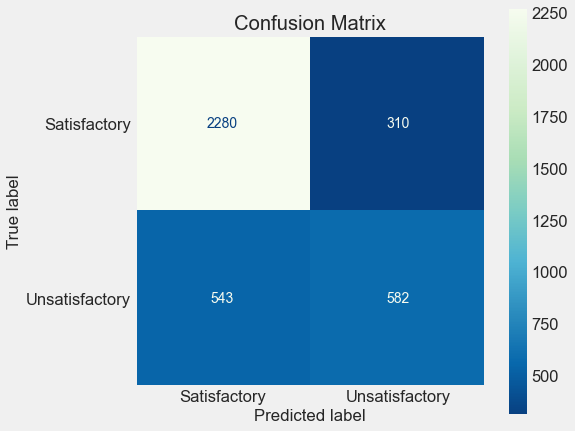

,Accuracy,F1,Recall,Precision
0,0.77039,0.577095,0.517333,0.652466


time: 18.9 s


In [37]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [38]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 2.14 ms


In [39]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 1.78 ms


### Fitting Model

In [40]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 4.82 s


In [41]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 1.44 ms


### Cross Val Scores

In [42]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7896633087753805
logreg_ss has an average F1 of 0.6060518815883744
logreg_ss has an average Recall of 0.5343813605890757
logreg_ss has an average Precision of 0.7001619072007813


[0.7896633087753805,
 0.6060518815883744,
 0.5343813605890757,
 0.7001619072007813]

time: 12.3 s


### Test Data Confusion Matrix

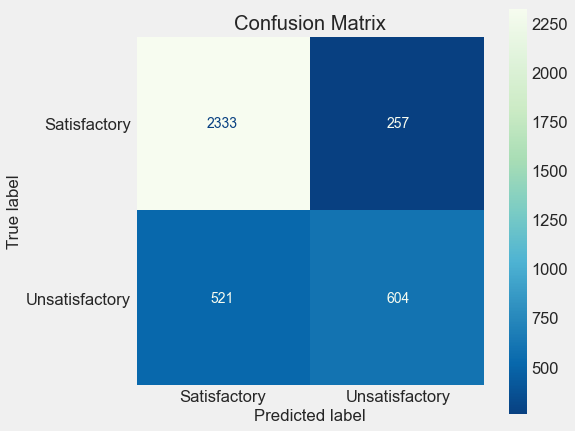

,Accuracy,F1,Recall,Precision
0,0.790579,0.608258,0.536889,0.70151


time: 573 ms


In [43]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [44]:
SVC = SVC()

time: 891 µs


In [45]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 1.84 ms


### Fitting Model

In [46]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('svc', SVC())])

time: 11 s


In [47]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 745 µs


### Cross Val Scores

In [48]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.8037510279464509
svc_ss has an average F1 of 0.6147437225164187
svc_ss has an average Recall of 0.5171895812726672
svc_ss has an average Precision of 0.7577147080010784


[0.8037510279464509,
 0.6147437225164187,
 0.5171895812726672,
 0.7577147080010784]

time: 33.2 s


### Test Data Confusion Matrix

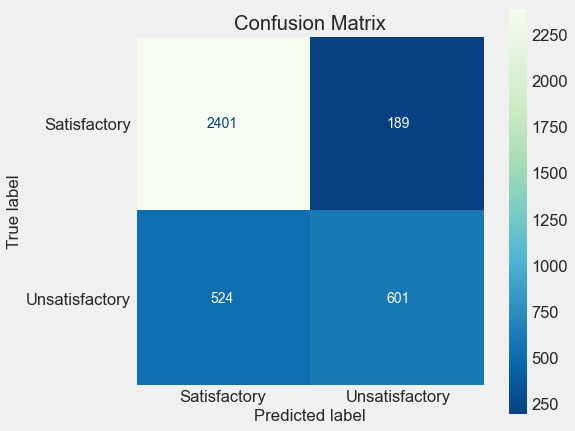

,Accuracy,F1,Recall,Precision
0,0.808075,0.627676,0.534222,0.760759


time: 11.1 s


In [49]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [50]:
LSVC = LinearSVC(random_state=2021)

time: 1.47 ms


In [51]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 1.21 ms


### Fitting Model

In [52]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('linearsvc', LinearSVC(random_state=2021))])

time: 1.27 s


In [53]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 895 µs


### Cross Val Scores

In [54]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7875097961987929
lsvc_ss has an average F1 of 0.5970091269484252
lsvc_ss has an average Recall of 0.5198593252005714
lsvc_ss has an average Precision of 0.7012224886544478


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.7875097961987929,
 0.5970091269484252,
 0.5198593252005714,
 0.7012224886544478]

time: 4.06 s


### Test Data Confusion Matrix

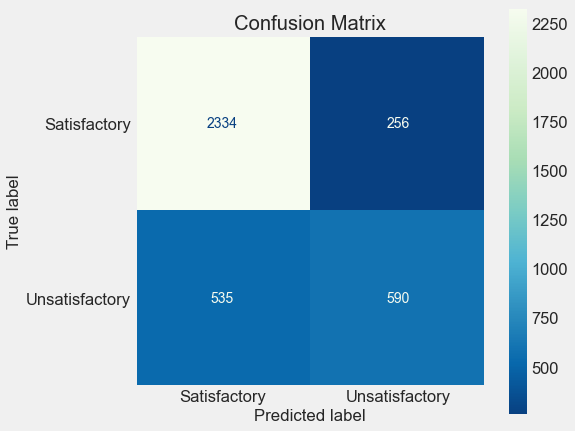

,Accuracy,F1,Recall,Precision
0,0.787079,0.598681,0.524444,0.6974


time: 286 ms


In [55]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [56]:
DT = DecisionTreeClassifier(random_state=2021)

time: 1.74 ms


In [57]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 1.29 ms


### Fitting Model

In [58]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 556 ms


In [59]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 780 µs


### Cross Val Scores

In [60]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.7685756467907532
dt_ss has an average F1 of 0.6202087836221717
dt_ss has an average Recall of 0.6244818111880427
dt_ss has an average Precision of 0.6162462347137806


[0.7685756467907532,
 0.6202087836221717,
 0.6244818111880427,
 0.6162462347137806]

time: 2.44 s


### Test Data Confusion Matrix

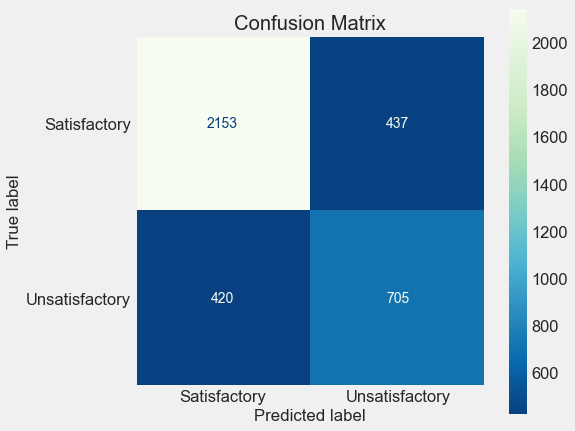

,Accuracy,F1,Recall,Precision
0,0.769314,0.621967,0.626667,0.617338


time: 330 ms


In [61]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [62]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 1.34 ms


In [63]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 1.54 ms


### Fitting Model

In [64]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 6.34 s


In [65]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 829 µs


### Cross Val Scores

In [66]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.8223258290222004
bclf_ss has an average F1 of 0.6732628924077686
bclf_ss has an average Recall of 0.6049161446312781
bclf_ss has an average Precision of 0.759384569507943


[0.8223258290222004, 0.6732628924077686, 0.6049161446312781, 0.759384569507943]

time: 42.4 s


### Test Data Confusion Matrix

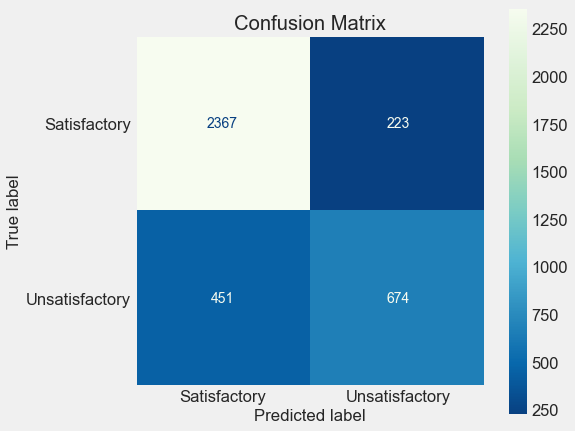

,Accuracy,F1,Recall,Precision
0,0.818573,0.666667,0.599111,0.751394


time: 1.95 s


In [67]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [68]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 2.18 ms


In [69]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 2.28 ms


### Fitting Model

In [70]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 6.22 s


In [71]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 1.57 ms


### Cross Val Scores

In [72]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.8195444737357166
rf_ss has an average F1 of 0.6682413959383661
rf_ss has an average Recall of 0.6001762831080338
rf_ss has an average Precision of 0.753811102034452


[0.8195444737357166, 0.6682413959383661, 0.6001762831080338, 0.753811102034452]

time: 19.4 s


### Test Data Confusion Matrix

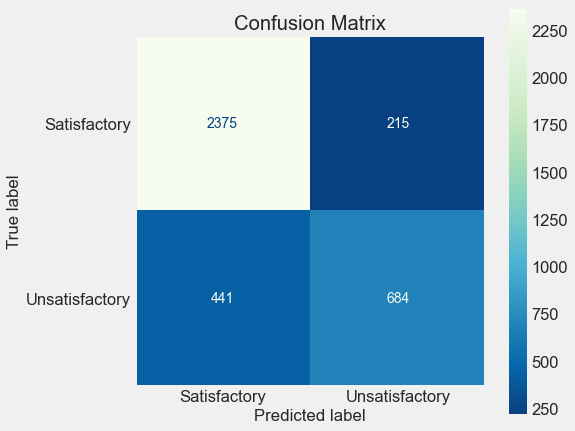

,Accuracy,F1,Recall,Precision
0,0.823419,0.675889,0.608,0.760845


time: 2.16 s


In [73]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [74]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 1.9 ms


In [75]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 2 ms


### Fitting Model

In [76]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 2.45 s


In [77]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 1.74 ms


### Cross Val Scores

In [78]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.7649863114985829
ada_ss has an average F1 of 0.6158836092780365
ada_ss has an average Recall of 0.6229990108803165
ada_ss has an average Precision of 0.6096794322907214


[0.7649863114985829,
 0.6158836092780365,
 0.6229990108803165,
 0.6096794322907214]

time: 8.46 s


### Test Data Confusion Matrix

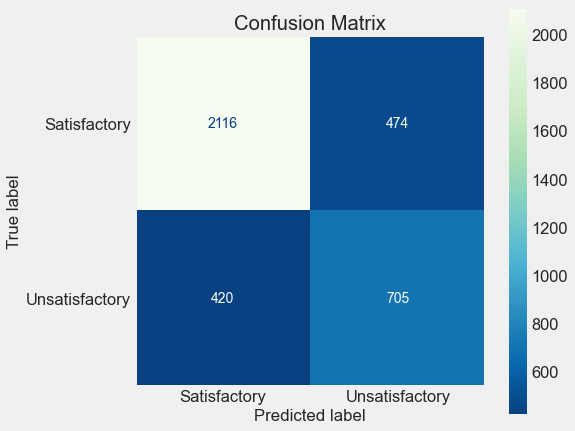

,Accuracy,F1,Recall,Precision
0,0.759354,0.611979,0.626667,0.597964


time: 1.23 s


In [79]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [80]:
XGB = XGBClassifier(use_label_encoder=False, verbosity=0)

time: 2.1 ms


In [81]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 1.65 ms


### Fitting Model

In [82]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 2.48 s


In [83]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 972 µs


### Cross Val Scores

In [84]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

[0.8257357519171554, 0.6853654758720866, 0.6274399384547753, 0.755422178379795]

time: 27.8 s


### Test Data Confusion Matrix

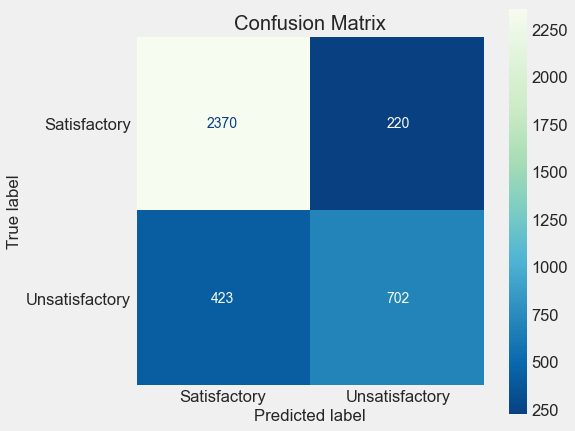

,Accuracy,F1,Recall,Precision
0,0.826918,0.685882,0.624,0.761388


time: 452 ms


In [85]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary

In [86]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.697236,0.000000,0.000000,0.000000,0.529826,Baseline DummyCFL
1,fsm,0.700108,0.196834,0.121522,0.519327,0.264023,FSM Naive Bayes
2,svc_ss,0.803751,0.614744,0.517190,0.757715,33.130377,Support Vector CLF SS()
3,lsvc_ss,0.787510,0.597009,0.519859,0.701222,4.047003,Linear SVC SS()
4,knn_ss,0.774587,0.582780,0.520154,0.662808,10.215346,KNN SS()
5,logreg_ss,0.789663,0.606052,0.534381,0.700162,12.330862,LogReg SS()
6,rf_ss,0.819544,0.668241,0.600176,0.753811,19.382696,Random Forest SS()
7,bclf_ss,0.822326,0.673263,0.604916,0.759385,42.245515,Bagging CLF SS()
8,ada_ss,0.764986,0.615884,0.622999,0.609679,8.411471,AdaBoost SS()
9,dt_ss,0.768576,0.620209,0.624482,0.616246,2.428674,Decision Tree CLF SS()


time: 13 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [87]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.33 ms


In [88]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 854 µs


### Fitting Model

In [89]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.24 s


In [90]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 912 µs


### Cross Val Scores

In [91]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

[0.8292356025075047,
 0.6866556932806557,
 0.6182521156171008,
 0.7724130864210357]

time: 19.6 s


### Test Data Confusion Matrix

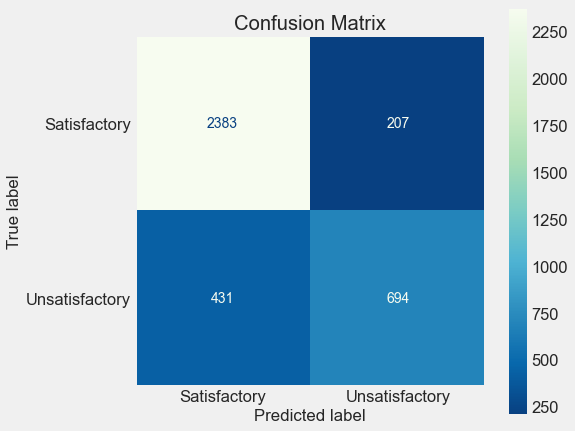

,Accuracy,F1,Recall,Precision
0,0.828264,0.685094,0.616889,0.770255


time: 977 ms


In [92]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [93]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.697236,0.000000,0.000000,0.000000,0.529826,Baseline DummyCFL
1,fsm,0.700108,0.196834,0.121522,0.519327,0.264023,FSM Naive Bayes
2,svc_ss,0.803751,0.614744,0.517190,0.757715,33.130377,Support Vector CLF SS()
3,lsvc_ss,0.787510,0.597009,0.519859,0.701222,4.047003,Linear SVC SS()
4,knn_ss,0.774587,0.582780,0.520154,0.662808,10.215346,KNN SS()
5,logreg_ss,0.789663,0.606052,0.534381,0.700162,12.330862,LogReg SS()
6,rf_ss,0.819544,0.668241,0.600176,0.753811,19.382696,Random Forest SS()
7,bclf_ss,0.822326,0.673263,0.604916,0.759385,42.245515,Bagging CLF SS()
11,vc_ss,0.829236,0.686656,0.618252,0.772413,19.562646,Voting CLF SS()
8,ada_ss,0.764986,0.615884,0.622999,0.609679,8.411471,AdaBoost SS()


time: 16 ms


## SMOTE

## XGBoost SMOTE

In [94]:
xgb_sm = make_sm_pipeline(preprocessing_ss, sm, XGB)

time: 1.13 ms


### Fitting Model

In [95]:
%%capture --no-display
xgb_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('smote', SMOTE(random_state=2...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
       

time: 2.57 s


In [96]:
# f.pickle_model(xgb_sm, 'xgb_sm')

time: 933 µs


### Cross Val Scores

In [97]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_sm, X_train, y_train, 'xgb_sm',\
                'XGBoost SS()/SMOTE')

[0.8270808414944831,
 0.6965210941770553,
 0.6564822507967908,
 0.7423388250554701]

time: 12.1 s


### Test Data Confusion Matrix

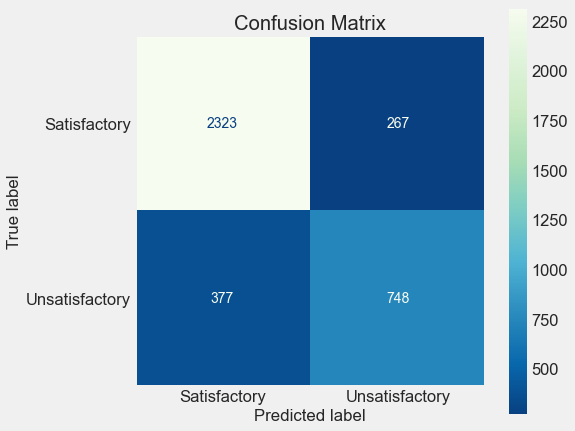

,Accuracy,F1,Recall,Precision
0,0.826649,0.699065,0.664889,0.736946


time: 463 ms


In [98]:
%%capture --no-display
f.confusion_report(xgb_sm, X_test, y_test)

## Voting CLF SMOTE

In [99]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [ ('bclf', clf1), ('rf', clf2), ('xgb', clf3)]
VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.9 ms


In [100]:
vc_ss = make_sm_pipeline(preprocessing_ss, sm, VC)

time: 1.1 ms


### Fitting Model

In [101]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('smote', SMOTE(random_state=2...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
                    

time: 9.88 s


In [102]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 776 µs


### Cross Val Scores

In [103]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()/SMOTE')

[0.8228633413152722,
 0.6947117430050259,
 0.6665594021321024,
 0.7257774621988672]

time: 33 s


### Test Data Confusion Matrix

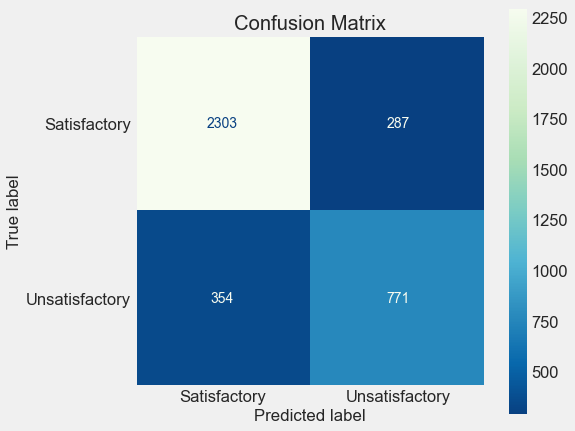

,Accuracy,F1,Recall,Precision
0,0.827456,0.706367,0.685333,0.728733


time: 1.01 s


In [104]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [106]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.697236,0.000000,0.000000,0.000000,0.529826,Baseline DummyCFL
1,fsm,0.700108,0.196834,0.121522,0.519327,0.264023,FSM Naive Bayes
2,svc_ss,0.803751,0.614744,0.517190,0.757715,33.130377,Support Vector CLF SS()
3,lsvc_ss,0.787510,0.597009,0.519859,0.701222,4.047003,Linear SVC SS()
4,knn_ss,0.774587,0.582780,0.520154,0.662808,10.215346,KNN SS()
5,logreg_ss,0.789663,0.606052,0.534381,0.700162,12.330862,LogReg SS()
6,rf_ss,0.819544,0.668241,0.600176,0.753811,19.382696,Random Forest SS()
7,bclf_ss,0.822326,0.673263,0.604916,0.759385,42.245515,Bagging CLF SS()
8,vc_ss,0.829236,0.686656,0.618252,0.772413,19.562646,Voting CLF SS()
9,ada_ss,0.764986,0.615884,0.622999,0.609679,8.411471,AdaBoost SS()


time: 12.9 ms


## Feature Importances

## XGBoost

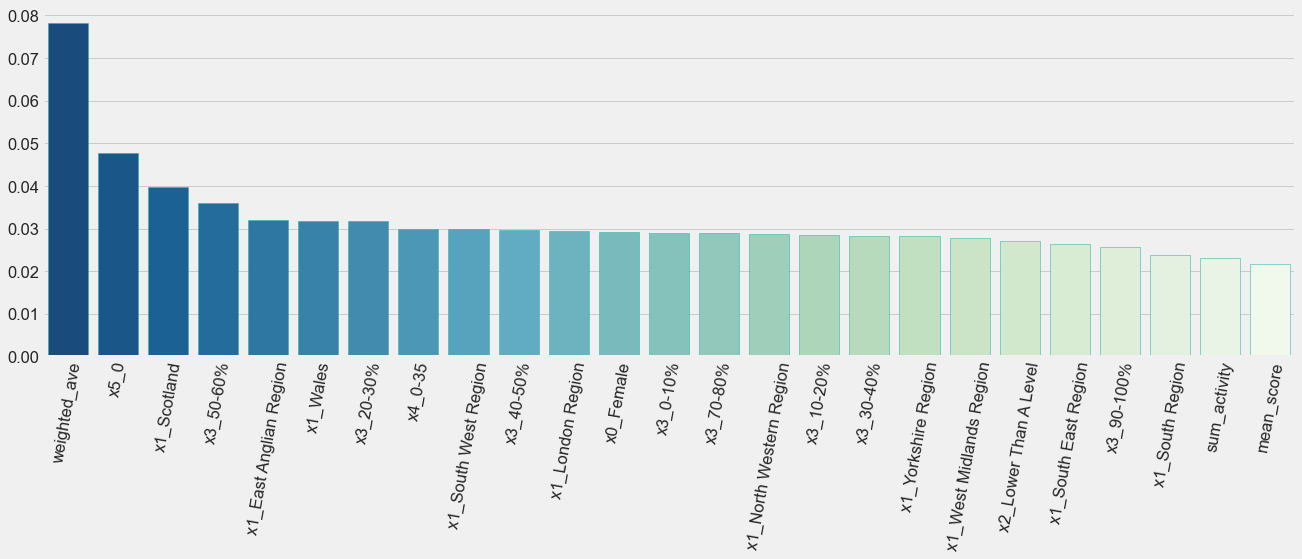

time: 458 ms


In [107]:
v.importance_plot_sm(xgb_sm, X_train)

In [108]:
# feature legend
keys = range(12)
f.get_features(keys, X_train)

0 gender
1 region
2 highest_education
3 imd_band
4 age_band
5 num_of_prev_attempts
6 disability
7 weighted_ave
8 mean_score
9 median_score
10 sum_activity
11 course_load
time: 1.4 ms


## Bagging Classifier

In [109]:
bclf_sm = make_sm_pipeline(preprocessing_ss, BCLF)
bclf_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.07 s


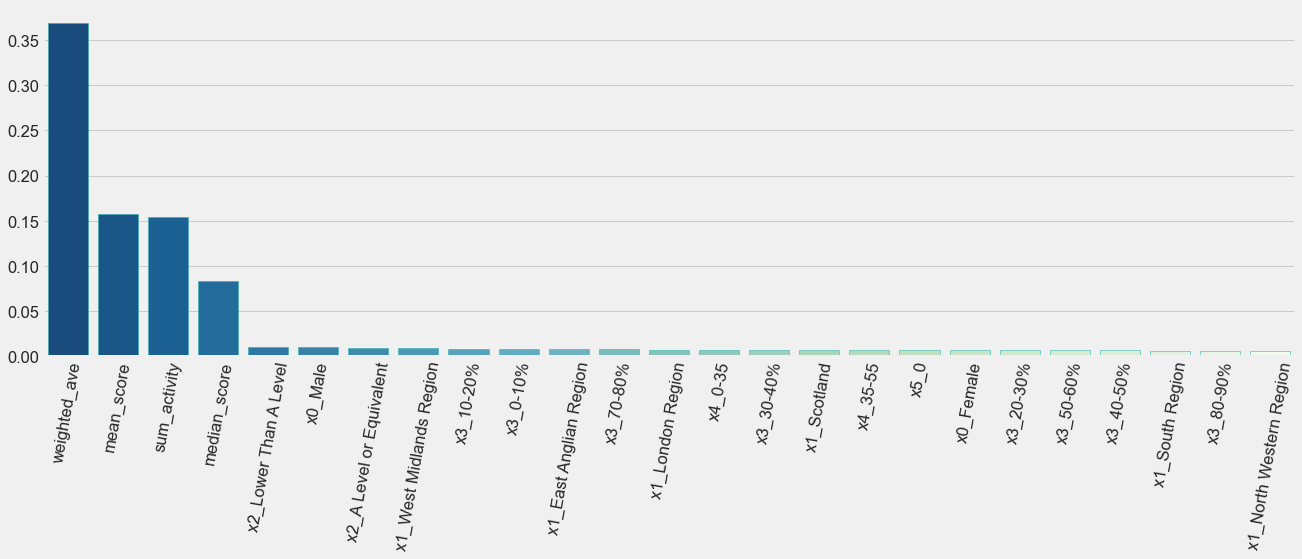

time: 414 ms


In [110]:
v.importance_plot_bclf(bclf_sm, X_train)

## Random Forest Classifier

In [111]:
rf_sm = make_sm_pipeline(preprocessing_ss, RF)
rf_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10d2f0c70>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.42 s


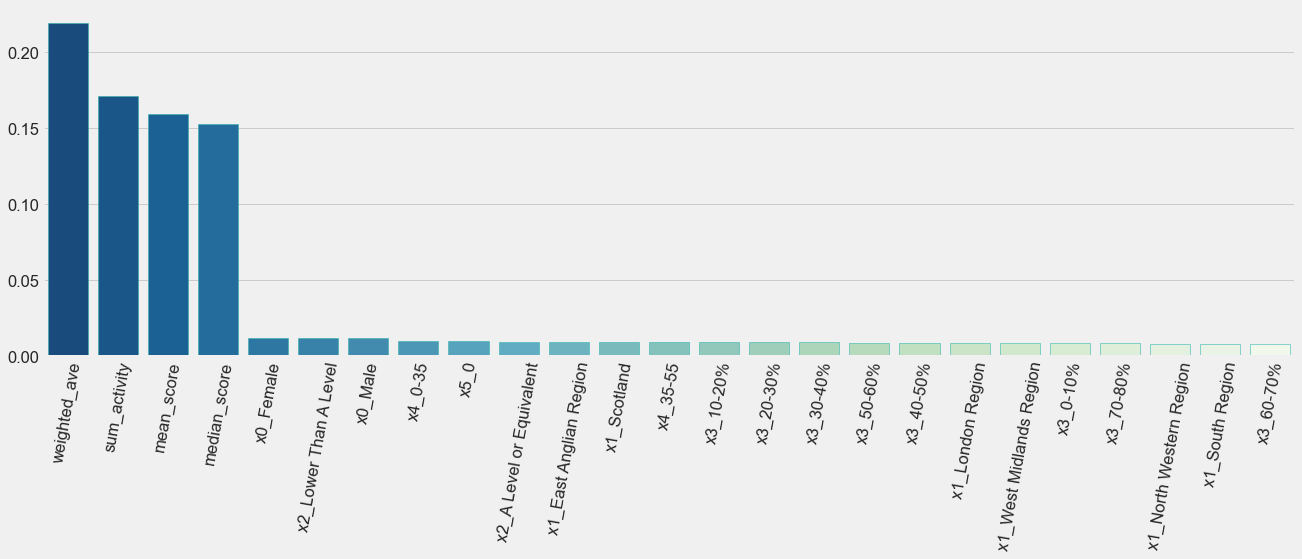

time: 307 ms


In [112]:
v.importance_plot(rf_sm, X_train)

## Permutation Importances

## Accuracy

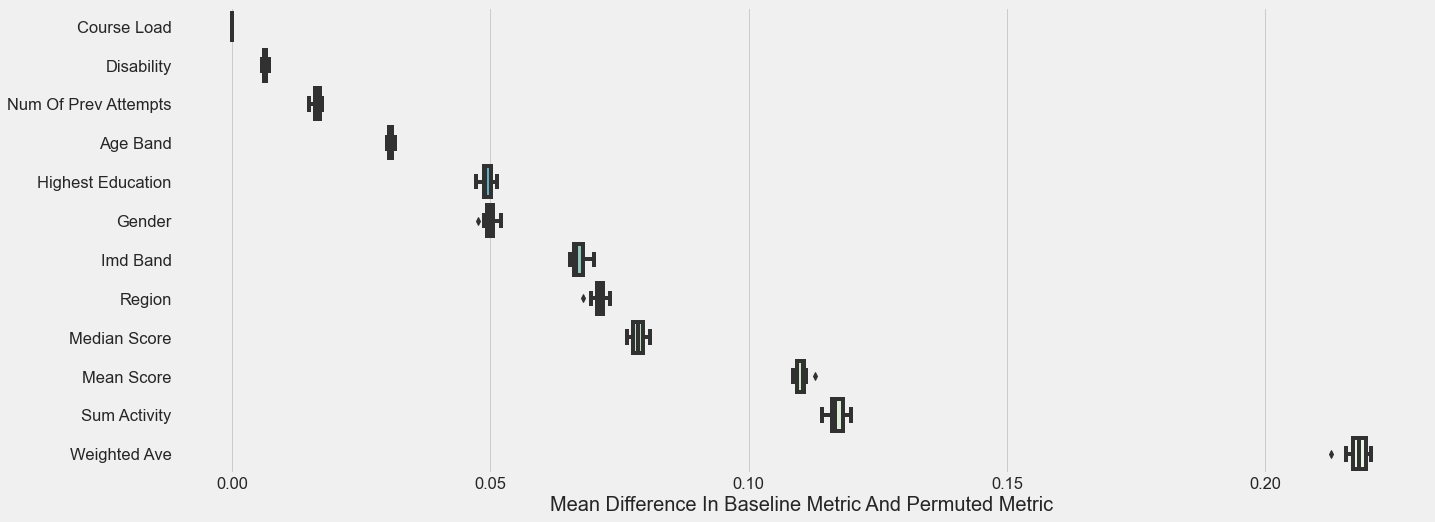

time: 22.7 s


In [113]:
f.perm_importances(vc_ss, X_train, y_train, 'accuracy')

## F1

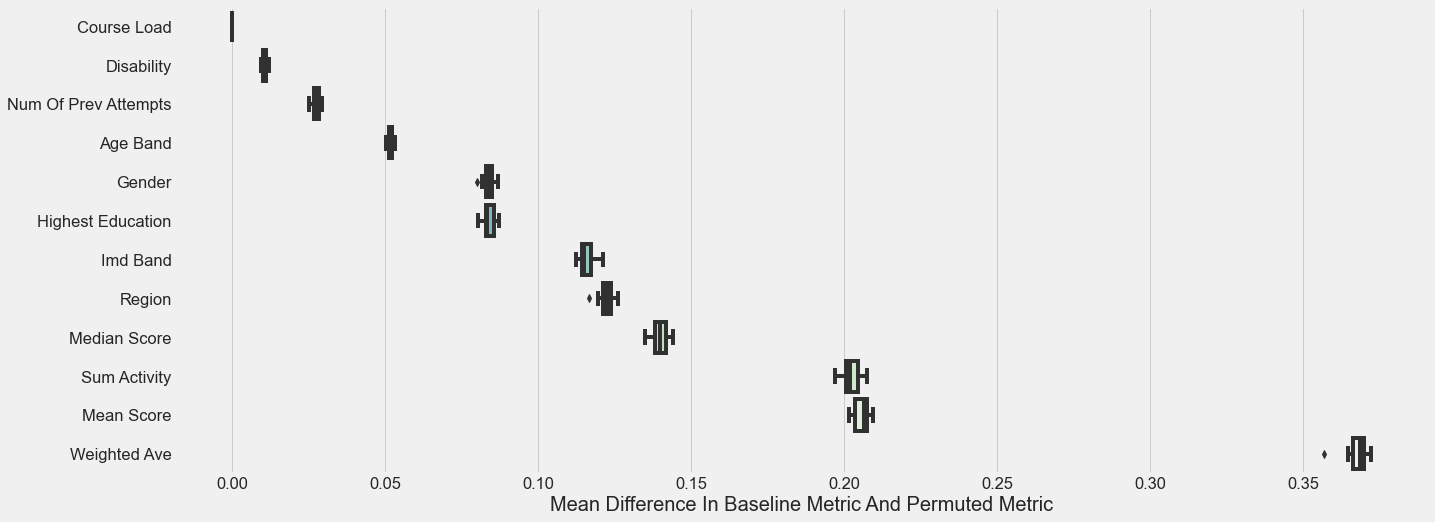

time: 23.2 s


In [114]:
f.perm_importances(vc_ss, X_train, y_train, 'f1')

## Recall

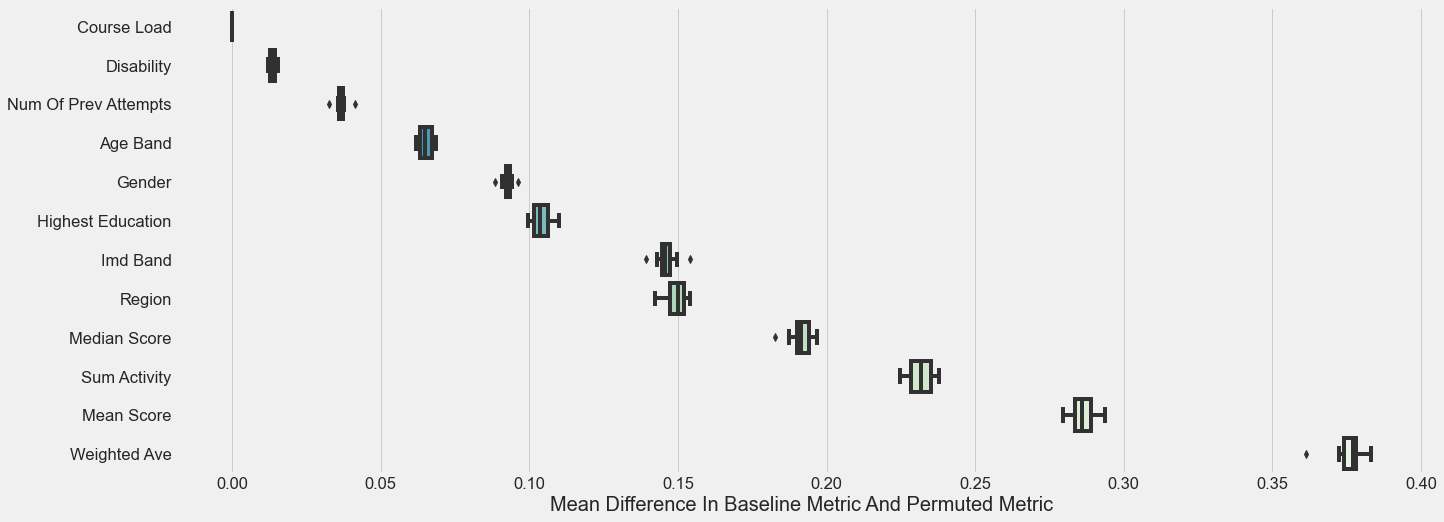

time: 23 s


In [115]:
f.perm_importances(vc_ss, X_train, y_train, 'recall')

## Precision

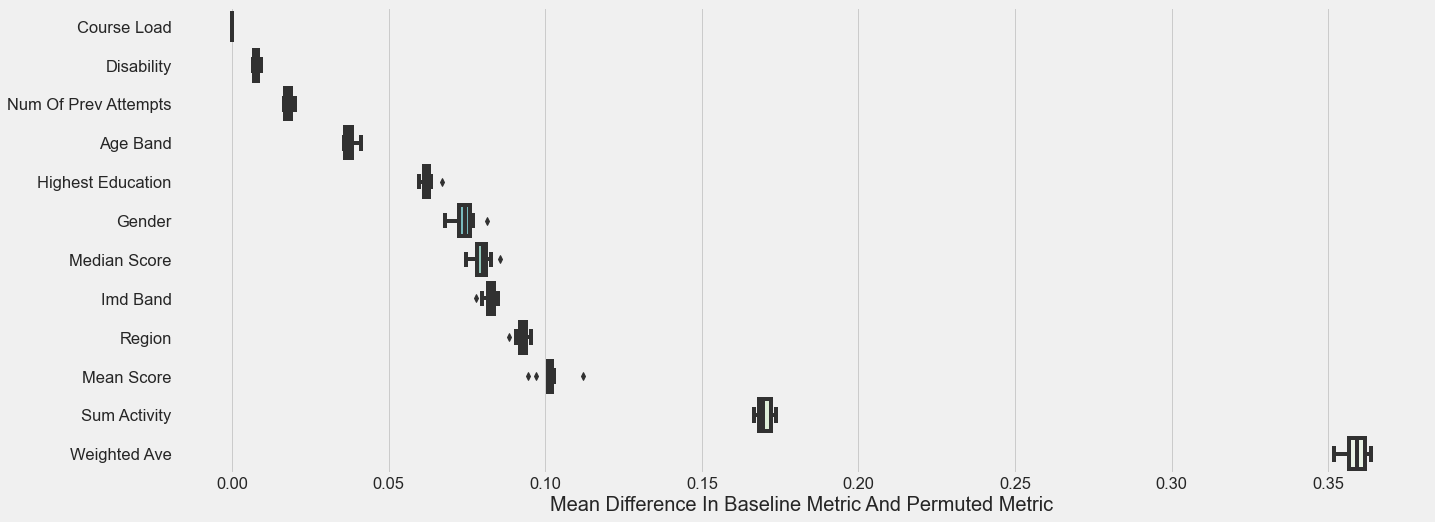

time: 22.6 s


In [116]:
f.perm_importances(vc_ss, X_train, y_train, 'precision')

In [117]:
%%capture --no-display
Audio(sound_file, autoplay=True)

time: 9.9 ms
